In [2]:
#Import Packages and other functions necessary for all of this to work

# Other Useful General Functions: 
# getcolormap, baseline, getMW, ABSORB, Test_GMM_Clusters
#from generalfunctions import getstats, get_PL_Raman_Current_Voltage_From_Matlab_File, Test_GMM_Clusters
#from mpl_toolkits.axes_grid1 import make_axes_locatable

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.mlab as mlab
import numpy as np

#used to take the derivative of noisy data
from scipy.interpolate import UnivariateSpline

#used to do fitting
from scipy.optimize import leastsq

#used for image segmentation and watershedding
from skimage import data, feature, filters
from skimage.filters import rank
from scipy import ndimage as ndi
from skimage.morphology import watershed, disk

# import clustering algorithms, distance calculations
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.decomposition import PCA, NMF

#set the useful functions to be used here:
def normalize_spectra_to_1(SPECTRA):
    #takes a matrix N x k where N is the number of observations and k is the number of variables(colums) and normalizes
    #each observation (row) to the maxiumum of all variables (colums)
    max_Spectra = np.ones((SPECTRA.shape[1],1)).dot(np.max(SPECTRA,axis=1)*np.ones((1,SPECTRA.shape[0]))).T
    SPECTRA/= max_Spectra
    return SPECTRA

def scale_spectra_0_1(SPECTRA):
    #takes a matrix N x k where N is the number of observations and k is the number of variables(colums) and scales
    #each observation (row) to range from 0 to 1
    max_Spectra = np.ones((SPECTRA.shape[1],1)).dot(np.max(SPECTRA,axis=1)*np.ones((1,SPECTRA.shape[0]))).T
    min_Spectra = np.ones((SPECTRA.shape[1],1)).dot(np.min(SPECTRA,axis=1)*np.ones((1,SPECTRA.shape[0]))).T
    return (SPECTRA-min_Spectra)/(max_Spectra-min_Spectra)

def lorentzian(x,p):
    #p = [width, center, amplitude]
    numerator =  (p[0]**2 )
    denominator = ( x - (p[1]) )**2 + p[0]**2
    y = p[2]*(numerator/denominator)
    return y

def errorfunc(p,x,z):
        return lorentzian(x,p)-z
    
def get_PL_Raman_Current_Voltage_From_Matlab_File(fpath):
    import scipy.io
    data = scipy.io.loadmat(fpath, mat_dtype=1) #mat_dtype=1 ensures that vars are imported as arrays
    #print data.keys()
    
    # the string in the brackets references the matlab data file name
    # the data is imported into python as a dictionary and this is how you reference the values
    
    x_coord_array = data['X'] # variable holding the x corrdinates
    y_coord_array = data['Y'] # variable holding the y coordinates

    PL = data["PL"]
    RAMAN = data["RAMAN"]

    wavenumber = data["wavenumber"]
    wavelength = data["wavelength"]

    wn = wavenumber.ravel() # data are imported as N x 1 matricies which complicates plotting later
    wl = wavelength.ravel() # ravel() removes the second dimension so it is an array of length N

    current = data["CURRENT"]
    voltage = data["VOLTAGE"]

    # calculates the step size based on the maximum difference in x and y dirrection to 3 decimal places
    x_step_size = round(np.diff(x_coord_array,axis=0).max(),3) 
    y_step_size = round(np.diff(y_coord_array,axis=0).max(),3) 

    #identifies the number of pixels in both the x and y directions
    x_pixels = int((x_coord_array.max() - x_coord_array.min())/x_step_size + 1)
    y_pixels = int((y_coord_array.max() - y_coord_array.min())/y_step_size + 1)
    
    #converts the number of pixels to a distance in microns based on the stepsize
    x = (np.arange(x_pixels)-x_pixels/2)*x_step_size
    y = (np.arange(y_pixels)-y_pixels/2)*y_step_size

    #send the data back to the user
    return data,PL,RAMAN,wl,wn,current,voltage,x,y,x_pixels,y_pixels    

['RAMAN', 'VOLTAGE_pl', 'wavenumber', 'RAMAN_volt', '__header__', '__globals__', 'CURRENT', 'VOLTAGE', 'wavelength', 'Y', 'X', '__version__', 'PL']


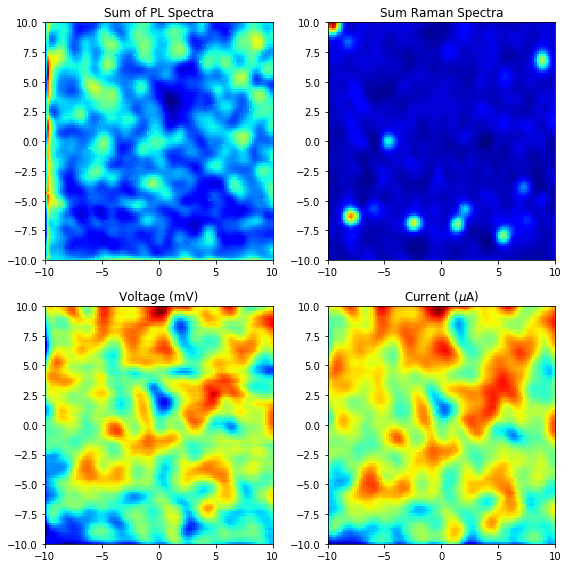

In [3]:
#Load the Spectrum Files and Electrical Data from a Pre-processed matlab file 
file_path_to_renishaw_data = 'F:/Ren_Data/AIST_slg_naf.mat'

#use parenthesis to break long lines of code over multiple lines
(dictionary_of_matlab_variables, 
 pl_spectra, raman_spectra, 
 pl_energy_wavelength, raman_energy_wavenumber, 
 current_amps, voltage_volts, 
 x_distance_um, y_distance_um, 
 number_of_x_pixels, number_of_y_pixels) = get_PL_Raman_Current_Voltage_From_Matlab_File(file_path_to_renishaw_data)

print dictionary_of_matlab_variables.keys() #show the names of variables stored in matlab file inorder to extract them

##### uncomment to use voltage from a different run on same sample
if file_path_to_renishaw_data == 'AIST_slg.mat' or file_path_to_renishaw_data == 'AIST_slg_naf.mat':
    voltage_volts = dictionary_of_matlab_variables["VOLTAGE_pl"] 

#create a map of the x and y coordinates by using meshgrid
x_position_map, y_position_map = np.meshgrid(x_distance_um, y_distance_um)

# spectra data has the shape [number_of_pixels, bins_in_energy_space]
#sum the spectra to find total intensity: (axis=1) means you sum across all energies
# summed_***_spectra now has shape  [number_of_pixels,]
summed_raman_spectra = np.sum(raman_spectra, axis=1)
summed_pl_spectra = np.sum(pl_spectra, axis=1)

#reshape the summed_spectra to be:
# [number_of_x_pixels, number_of_y_pixels]
summed_pl_spectra_matrix = np.reshape(summed_pl_spectra, (number_of_x_pixels, number_of_y_pixels))
summed_raman_spectra_matrix = np.reshape(summed_raman_spectra, (number_of_x_pixels, number_of_y_pixels))
current_map_uA = np.reshape(current_amps*1E6, (number_of_x_pixels, number_of_y_pixels))
voltage_map_mV = np.reshape(voltage_volts*1E3, (number_of_x_pixels, number_of_y_pixels))

#Visualize the Data
f,ax = plt.subplots(2,2,figsize=(8,8))
ax[0,0].pcolor(x_position_map, y_position_map, summed_pl_spectra_matrix, cmap='jet')
ax[0,0].set_title('Sum of PL Spectra')
ax[0,1].pcolor(x_position_map, y_position_map, summed_raman_spectra_matrix, cmap='jet')
ax[0,1].set_title('Sum Raman Spectra')
ax[1,1].pcolor(x_position_map, y_position_map, current_map_uA, cmap='jet')
ax[1,1].set_title('Current ($\mu$A)')
ax[1,0].pcolor(x_position_map, y_position_map, voltage_map_mV, cmap='jet')
ax[1,0].set_title('Voltage (mV)')
plt.tight_layout()



plt.show()

(10201L, 765L)
1.0


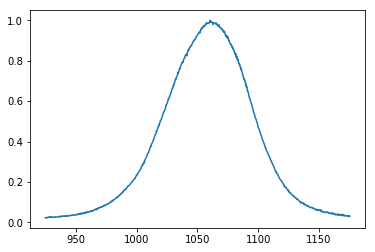

In [4]:
print pl_spectra.shape
SPECTRA = normalize_spectra_to_1(np.array(pl_spectra))
print np.max(SPECTRA)
plt.plot(pl_energy_wavelength.T,SPECTRA[500,:])
plt.show()

PCA Variance:  [ 86.49   5.5 ]


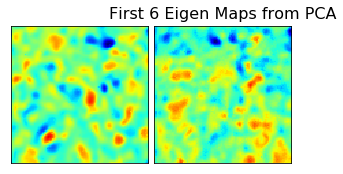

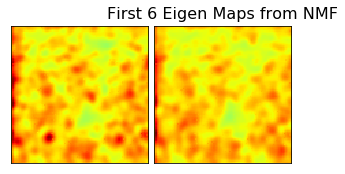

In [35]:
n_col, n_row = 3, 2
def plot_gallery(title, images, n_col=n_col, n_row=n_row):
    plt.figure(figsize=(2. * n_col, 2.26 * n_row))
    plt.suptitle(title, size=16)
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i + 1)
        vmax = max(comp.max(), -comp.min())
        plt.imshow(comp.reshape(image_shape), cmap='jet',
                   interpolation='nearest',
                   vmin=-vmax, vmax=vmax)
        plt.xticks(())
        plt.yticks(())
    plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)

image_shape = (101, 101)
n_samples, n_features = pl_spectra.T.shape

n_components = 2
n_clusters = 4

#X = normalize_spectra_to_1(pl_spectra.T)

# global centering
pl_centered = SPECTRA - SPECTRA.mean(axis=0)

pca = PCA(n_components=n_components, svd_solver='randomized',
                       whiten=True)
nmf = NMF(n_components=n_components, init='nndsvda', tol=5e-3)

pca.fit(pl_centered.T)
nmf.fit(pl_spectra.T)

print 'PCA Variance: ', np.round(pca.explained_variance_ratio_*100,2) 
#print 'NMF Variance: ', np.round(nmf.explained_variance_ratio_,2)*100 


pca_components_ = pca.components_
nmf_components_ = nmf.components_


plot_gallery("First 6 PL maps", pl_centered[100:100:600,:])
plot_gallery('First 6 Eigen Maps from PCA',  pca_components_[:n_components])
plot_gallery("First 6 Eigen Maps from NMF",  nmf_components_[:n_components])
plt.show()

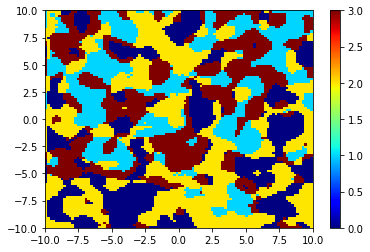

In [36]:
# def elbow_curve(data, max_cluster, cluster_method):
#     total_variance = np.var(data)
#     print total_variance
#     elbow = []
#     for k in range(2,max_cluster+1):
#         clf = cluster_method(n_clusters=k)
#         labels = clf.fit_predict(data)
#         clf_variance = 0.
#         for i in range(0,k):
#             clf_variance+= np.var(data[labels==i,:])/total_variance
#         elbow.append(clf_variance)
        
#     return elbow

# elbow = elbow_curve(nmf_components_[0:1,::20].T,8,KMeans)
from sklearn.mixture import GaussianMixture
#clf = GaussianMixture(n_components=3, covariance_type='full')

data = pca_components_
clf = KMeans(n_clusters=n_clusters)
labels = clf.fit(data.T).predict(data.T).reshape(101,101)
plt.pcolor(x_distance_um,y_distance_um,labels,cmap='jet')
plt.colorbar()
plt.show()

(2L, 10201L)
(2L, 10201L)


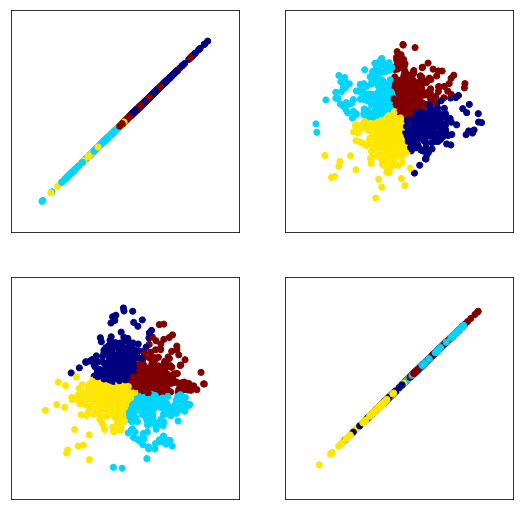

In [37]:
print nmf_components_.shape
print pca_components_.shape

step = 10

#data = nmf_components_
fig, axes = plt.subplots(n_components,n_components,figsize=(9,9),sharex='row',sharey= 'col')
for idx1 in range(n_components):
    for idx2 in range(n_components):
        axes[idx1,idx2].scatter(data[idx1,::step],data[idx2,::step],c=labels.ravel()[::step].astype(np.float),cmap = 'jet')
        #axes[idx1,idx2].set_axis_off()
        #axes[idx1,idx2].subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
        axes[idx1,idx2].margins(0,0)
        axes[idx1,idx2].xaxis.set_major_locator(plt.NullLocator())
        axes[idx1,idx2].yaxis.set_major_locator(plt.NullLocator())
        
        #axes[idx1,idx2].set_ylabel('Component '+ str(idx2))
        #axes[idx1,idx2].set_xlabel('Component '+ str(idx1))
#plt.tight_layout()
plt.show()

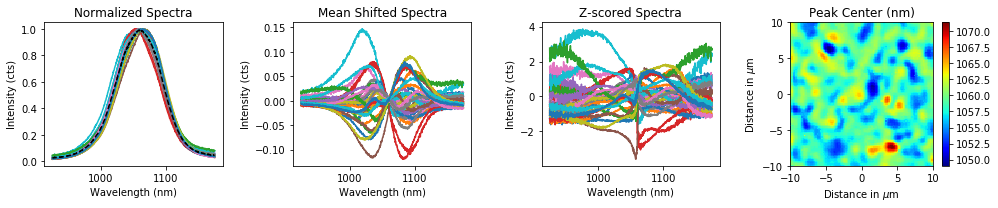

In [38]:
sum_spec = np.cumsum(pl_spectra,axis=1) # calulates the cumulative sum across each row
norm_sum_spec = normalize_spectra_to_1(sum_spec)

#where the normalized cumulative sum == 0.5 is the center of the distrubiton
#subtracting 0.5 from the data and taking the absolute value means that values near 0.5 will be close to zero
#taking the minimum of this will give you the center position
find_center_index = np.argmin(np.abs(norm_sum_spec-0.5),axis=1) 

#generate an empty array to store the energy center values 
peak_centers = np.ma.empty((norm_sum_spec.shape[0],1))
for i in range(norm_sum_spec.shape[0]):
    peak_centers[i] = pl_energy_wavelength[find_center_index[i]]


#reshape the array to be vsiualized as a map in X,Y coordinates 
peak_center_matrix = np.reshape(peak_centers,(number_of_x_pixels,number_of_x_pixels))

'''
Normalize all PL spectra to 1
Visualize the deviations from the mean (set mean of the data == 0)
Visualize zscored PL spectra, force the standard deviation to be 1
'''

#normalize the data by the maximum of each pl spectrum
features = SPECTRA

# subtract the average pl spectrum from every spectra such that mean(pl_spectra[:,Energy]) = 0
mfeatures = (features -np.mean(features, axis=0)) 

# set the standard deviation of each energy bin to 1
zfeatures = (features -np.mean(features, axis=0))/np.std(features,axis=0)

#plot every INTERVAL of pixels
interval = 333
Energy = pl_energy_wavelength

fig, ax = plt.subplots(1,4,figsize=(14,3))
ax[0].plot(Energy.T,features[::interval,:].T,Energy.T,np.mean(features,axis=0),'--k') # need to transpose because the first dimension needs to be the same 
ax[1].plot(Energy.T,mfeatures[::interval,:].T)
ax[2].plot(Energy.T,zfeatures[::interval,:].T)
pcm = ax[3].pcolor(x_distance_um,y_distance_um,peak_center_matrix,cmap='jet')
fig.colorbar(pcm,ax = ax[3])

title = ['Normalized Spectra','Mean Shifted Spectra','Z-scored Spectra','Peak Center (nm)']
for counter,a in enumerate(ax):
    a.set_title(title[counter])
    a.set_xlabel('Wavelength (nm)')
    a.set_ylabel('Intensity (cts)')
    if counter == 3:
        a.set_xlabel('Distance in $\mu$m')
        a.set_ylabel('Distance in $\mu$m')
plt.tight_layout()
plt.show()

0 of  10201
500 of  10201
1000 of  10201
1500 of  10201
2000 of  10201
2500 of  10201
3000 of  10201
3500 of  10201
4000 of  10201
4500 of  10201
5000 of  10201
5500 of  10201
6000 of  10201
6500 of  10201
7000 of  10201
7500 of  10201
8000 of  10201
8500 of  10201
9000 of  10201
9500 of  10201
10000 of  10201
The time to find the PL FWHM for  10200  pixels is  1.68 seconds


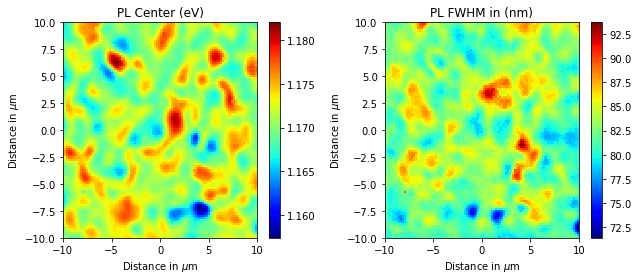

In [13]:
#fwhm
def FWHM(X,Y):
    half_max = max(Y) / 2.
    max_idx = np.argmax(Y)
    left_idx = np.argmin(np.abs(Y[0:max_idx]-half_max))
    right_idx = np.argmin(np.abs(Y[max_idx::]-half_max))+ max_idx
    return X[right_idx] - X[left_idx] #return the difference (full width)

from time import time

t0 = time()
pl_FWHM = np.zeros((pl_spectra.shape[0],1)).ravel()
for i in range(len(pl_FWHM)):
    if i % 500 == 0:
        print i, 'of ', len(pl_FWHM)
    Y = pl_spectra[i,:]
    X = pl_energy_wavelength
    pl_FWHM[i] = FWHM(X,Y)
    
print 'The time to find the PL FWHM for ', i ,' pixels is ', round(time()-t0,2), 'seconds'
#pl_FWHM[pl_FWHM == 0] = np.ma.masked
pl_FWHM_map = np.reshape(pl_FWHM,(number_of_x_pixels,number_of_x_pixels))

f,axes = plt.subplots(1,2,figsize=(9,4))
ax = axes.ravel()
data = [1240/peak_center_matrix, pl_FWHM_map]
title = ['PL Center (eV)','PL FWHM in (nm)']
for idx in range(len(ax)):
    pcm = ax[idx].pcolor(x_distance_um,y_distance_um,data[idx],cmap='jet')
    ax[idx].set_title(title[idx])
    ax[idx].set_xlabel('Distance in $\mu$m')
    ax[idx].set_ylabel('Distance in $\mu$m')         
    f.colorbar(pcm,ax = ax[idx])
plt.tight_layout()
plt.show()

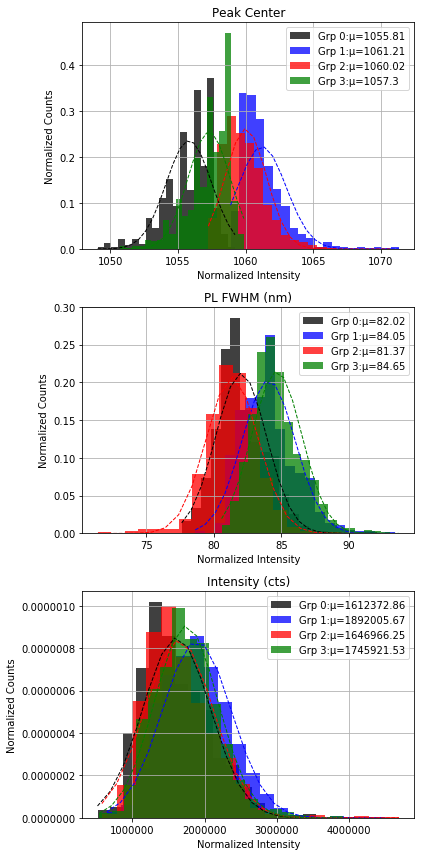

In [39]:
#hist_data_all = [peak_center_matrix,masked_maps[-2],masked_maps[-1],I_data[-1],I_data[0],I_data[1]]
hist_data_all = [peak_center_matrix, pl_FWHM_map, summed_pl_spectra]

#hist_data_all = other_data
#titles = ['Peak Center','Voltage','Current','Intensity at '+str(switches[-1]),'Intensity at '+str(switches[0]),'Intensity at '+str(switches[1])]
titles = ['Peak Center','PL FWHM (nm)','Intensity (cts)']

c = ['black','blue','red','green','gray','yellow']

fig,axes = plt.subplots(3,1,figsize=(6,12))
ax = axes.ravel()
for a,hist_data_a,tit in zip(ax,hist_data_all,titles):
    hist_data_a = hist_data_a.ravel()
    for idx in range(np.max(labels)+1):
        hist_data = hist_data_a[labels.ravel()==idx]
        mu = np.mean(hist_data)
        sigma = np.std(hist_data)
        n, bins, patches = a.hist(hist_data.ravel(), 20, normed=1, facecolor=c[idx], alpha=0.75,label = 'Grp '+ str(idx)+':'+ u"\u00B5" +'='+str(round(mu,2)))
        # add a 'best fit' line
        y = mlab.normpdf( bins, mu, sigma)
        l = a.plot(bins, y, linestyle='--',color=c[idx], linewidth=1)
    a.set_xlabel('Normalized Intensity')
    a.set_ylabel('Normalized Counts')
    a.set_title(tit)
    #plt.axis([40, 160, 0, 0.03])
    a.grid(True)
    a.legend()
plt.tight_layout()
plt.show()

Cluster  0 has  2260  data points
Cluster  1 has  2165  data points
Cluster  2 has  3196  data points
Cluster  3 has  2580  data points


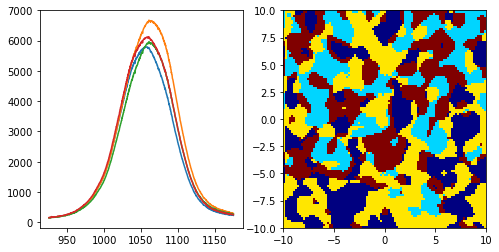

In [41]:
#print labels.ravel() == 3
avg_specs = np.zeros((4,len(pl_energy_wavelength)))

for k in range(4):
    avg_specs[k,:] = np.mean(pl_spectra[labels.ravel()==k,:],axis=0)
    print 'Cluster ', k, 'has ', np.sum(labels.ravel() == k), ' data points'
l = [0, 1, 2, 3, 4]
fig, ax = plt.subplots(1,2,figsize=(8,4))
ax[0].plot(pl_energy_wavelength.T,avg_specs.T, label = '')
ax[0].legend()
ax[1].pcolor(x_distance_um,y_distance_um,labels,cmap='jet')
plt.show()

In [ ]:
test_map = np.array(labels)
test_map[labels == ]